# MAD Competition

Maximum differentiation (MAD) competition comes from a paper published in 2008 by Zhou Wang and Eero Simoncelli ([reprint](https://www.cns.nyu.edu/pub/lcv/wang08-preprint.pdf) from LCV website). In MAD Competition, the goal is to efficiently compare two competing models. As in all synthesis methods in `plenoptic`, the models operate on images and produce predictions related to perception. As originally conceived, the models in MAD competition are perceptual metrics: they take two images and return a scalar value that gives a perceptual distance; the smaller this number is, the more perceptually similar the metric predicts they will be. In `plenoptic`'s implementation, MAD competition can work with either perceptual metrics, which are functions that do the above, or models. In `plenoptic`, models are classes which take a single image and return a 1d or 2d representation; the perceptual distance between two images is then the distance between the two representations. By default, we use the L2-norm of the difference between these representations, but other distance metrics can be used.

For MAD competition, you specify the two models or metrics you wish to compare and a target image. MAD competition then adds some Gaussian noise to the target image (we'll call this the "initial image") and synthesizes four images: 
1. `model_1_min`: model 1 thinks this image is as similar to the target image as possible, while model 2 thinks it's as similar to the initial image as possible
2. `model_1_max`: model 1 thinks this image is as different to the target image as possible, while model 2 thinks it's as similar to the initial image as possible
1. `model_2_min`: model 2 thinks this image is as similar to the target image as possible, while model 1 thinks it's as similar to the initial image as possible
2. `model_2_max`: model 2 thinks this image is as different to the target image as possible, while model 1 thinks it's as similar to the initial image as possible

(where when I say a "model thinks", I mean the model's perceptual distance, so "model thinks is as similar as possible" means that the model's perceptual distance is as small as possible)

You can see these four images fall into two pairs and in each pair, one model thinks it's the same as the initial image, while the other thinks it's as different / similar to the target image as possible. This gives us a set of images for efficiently comparing the two models.

That's the general idea, now let's explore how to use the `MADCompetition` class for generating these images

In [1]:
import plenoptic as po
import imageio
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

## Basic usage

As with all our synthesis methods, we start by grabbing a target image and initalizing our models.

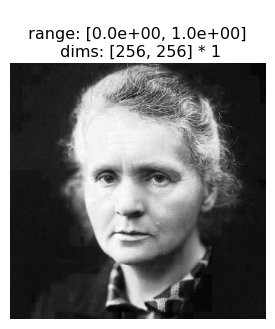

In [2]:
img = po.tools.data.load_images(['../data/curie.pgm'])
pt.imshow(img.squeeze());

To start, we'll demonstrate MAD competition as described in the paper, using two metrics: SSIM (structural similarity index, described [here](https://www.cns.nyu.edu/pub/lcv/wang03-preprint.pdf)) and MSE (mean-squared error), implementations for both of which are found in `plenoptic.metric`. 

In [3]:
model1 = po.metric.ssim
model2 = po.metric.mse

To intitialize the method, we only need to specify the target image (as a 4d tensor, as returned by `load_images`) and the two models

In [4]:
mad = po.synth.MADCompetition(img, model1, model2)

At the most basic, all we need to do is call `mad.synthesize()`, specifying the target image. Let's start with `model_1_min`, and then view the outcome (we set `store_progress=True` so that we store the synthesis progress as well as the final outcome). There are many additional possible arguments to `synthesize()` but only `synthesis_target` is required.

100%|██████████| 200/200 [00:35<00:00,  4.01it/s, gradient_norm=2.0165e-02, learning_rate=1, loss=2.5065e-01, stable_loss=1.0512e+00]
/home/billbrod/Documents/plenoptic/plenoptic/synthesize/Synthesis.py:794: UserWarning: Since at least one of your models is a metric, its representation_error will be meaningless -- it will just show the pixel-by-pixel difference. (Your loss is still meaningful, however, since it's the actual metric)
  warnings.warn("Since at least one of your models is a metric, its representation_error"
/home/billbrod/Documents/plenoptic/plenoptic/synthesize/mad_competition.py:1730: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")
/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:385: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


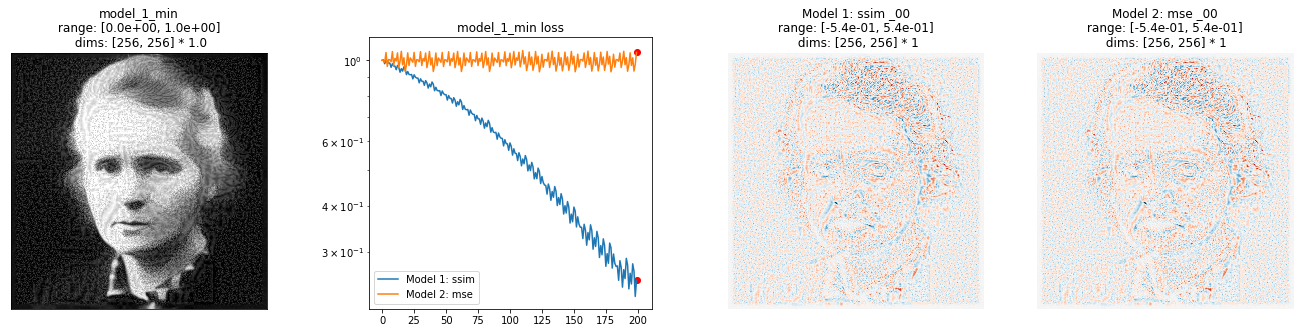

In [5]:
mad.synthesize('model_1_min', store_progress=True, max_iter=200)
fig = mad.plot_synthesis_status()

We can see from the loss plot that SSIM's loss is decreasing, while MSE's is staying roughly constant.

One of the warnings raised by this function should draw our attention "Since at least one of your models is a metric, ts representation_error will be meaningless...", and in fact we can see that the two plots on the right look identical and uninformative (they're simply giving the pixel-by-pixel difference between the target image and our synthesized image.

In order to get a more meaningful representation error plot, we'll need to use a class for our model. We don't have a class implementation for SSIM (this would be a great contribution!) but we do have one for a NLPD (normalized Laplacian pyramid distance, described [here](https://www.cns.nyu.edu/pub/lcv/laparra17-reprint.pdf)).

Note that we also switch the MSE model to a class, using `plenoptic.simul.models.naive.Identity()`. This simple model just returns a copy of the input image (since our synthesis's default distance metric is not MSE by the L2-norm of the distance, this is slightly different than above).

100%|██████████| 200/200 [00:32<00:00,  6.19it/s, gradient_norm=1.5721e-02, learning_rate=1, loss=6.5313e-01, stable_loss=1.0144e+00]


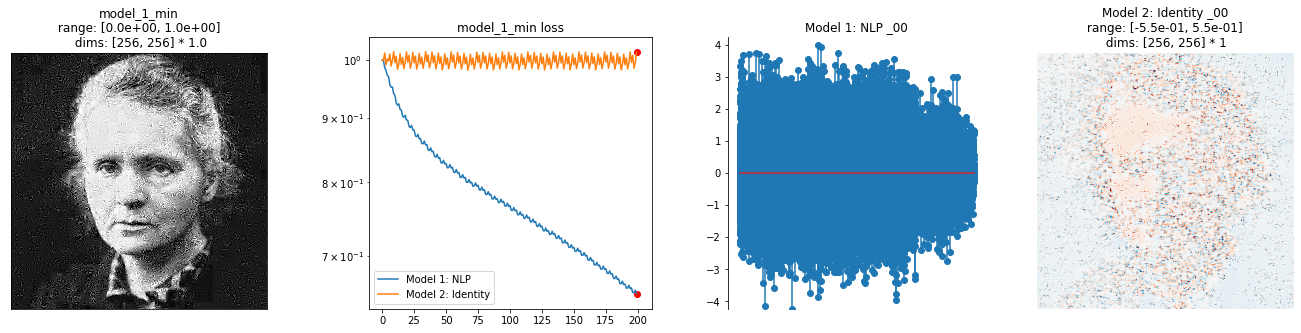

In [6]:
model1 = po.metric.NLP()
model2 = po.simul.models.naive.Identity()

mad = po.synth.MADCompetition(img, model1, model2)

mad.synthesize('model_1_min', store_progress=True, max_iter=200)
fig = mad.plot_synthesis_status()

We now see that the model 1 representation plot is a stem plot. Let's step through what that means.

When we call `model1(img)`, it returns a 3d tensor (the first two dimensions are batch and channel, which we'll ignore for now). This is what we refer to as the model's representation. The stem plot above, then, just shows the difference in the model's representation of the synthesized image and the target image. Its main use is to see if there are parts of the model where the difference is large / small, to see if some element of the optimization has gotten stuck. It doesn't look like that here -- all elements look like they're approximately the same magnitude (though some are negative and some are positive), though it's clear there's plenty more optimization to do!

In [7]:
print(model1(img))
print(model1(img).shape)

tensor([[[-0.4417, -0.3183,  0.0624,  ...,  2.6837,  1.5865,  1.7153]]])
torch.Size([1, 1, 87360])


What do these numbers mean? The Normalized Laplacian Pyramid returns activations at several scales (where scale is down-sampled by a factor of 2 from the previous), and the simple `NLP` class just flattens and concatenates them into a single vector. This is fine for optimization purposes, but means that we're throwing away information that may be useful for better understanding the optimization. For an example of how to handle that, see the `PrimaryVisualCortex` model, which also returns a flattened tensor on the forward pass, but rearranges it into more informative shapes for plotting. For more information on Laplacian pyramids, see the examples in the [pyrtools documentation](https://pyrtools.readthedocs.io/en/latest/tutorials/tutorial2.html), and for more info on how the Normalized Laplacian differs, see the [paper referenced above](https://www.cns.nyu.edu/pub/lcv/laparra17-reprint.pdf).

As described in the opening paragraph, a full set of MAD competition synthesized images consists of four images. We can make the rest by calling `synthesize()` with a different `target` argument (we use the same `MADCompetition` object; it holds onto the history of each synthesis separately, in dictionary attributes with the `_all` suffix, e.g., `mad.matched_image_all`).

100%|██████████| 200/200 [01:37<00:00,  2.04it/s, gradient_norm=3.1926e-02, learning_rate=0.0625, loss=5.2893e-01, stable_loss=9.9220e-01]


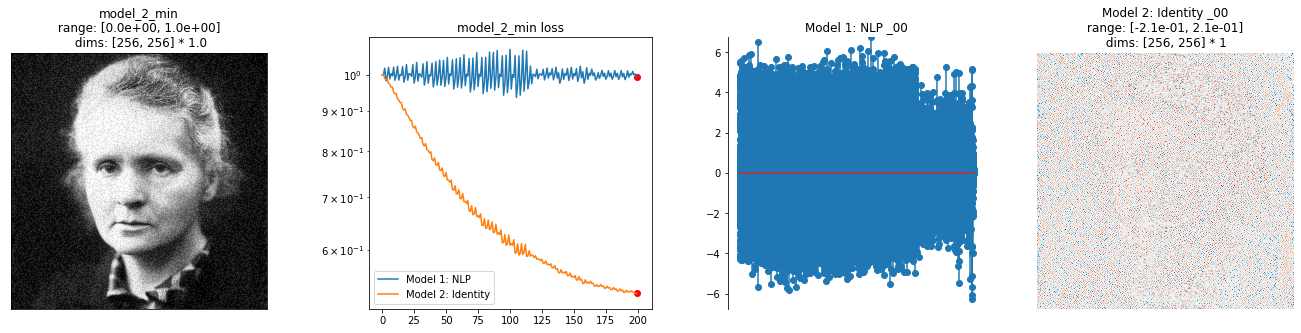

In [8]:
mad.synthesize('model_2_min', store_progress=True, max_iter=200)
fig = mad.plot_synthesis_status()

We provide a convenience function, `synthesize_all()`, which will synthesize all targets in a single call (one of its arguments determines what to do if one target has been run before; the default is to skip, but see docstring for details).

Note that `model_2_max` takes much longer than `model_1_max`. This is because on each iteration of the synthesis, we run a "stable loop", which attempts to stabilize the other model's loss, and doing this with `NLP` takes much longer than doing this with `Identity`.

In [9]:
mad.synthesize_all(store_progress=True, max_iter=200)

  0%|          | 0/200 [00:00<?, ?it/s, gradient_norm=4.6911e-02, learning_rate=1, loss=1.0000e+00, stable_loss=1.0000e+00]

Synthesis with target model_1_min has been run before, skipping
Synthesizing model_1_max


  0%|          | 0/200 [00:00<?, ?it/s, gradient_norm=3.9134e-02, learning_rate=1, loss=1.0000e+00, stable_loss=1.0000e+00]

Synthesis with target model_2_min has been run before, skipping
Synthesizing model_2_max


100%|██████████| 200/200 [01:23<00:00,  2.70it/s, gradient_norm=4.3481e-02, learning_rate=0.0312, loss=8.5339e+00, stable_loss=1.0180e+00]


We similarly provide convenience functions to view all synthesis losses

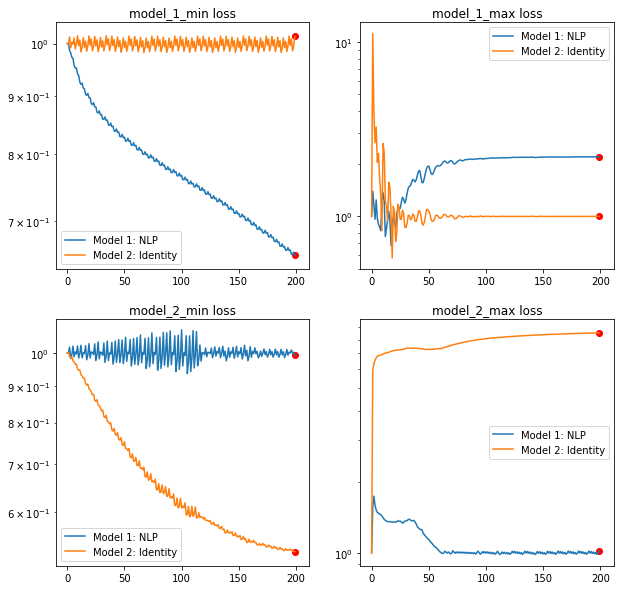

In [10]:
fig = mad.plot_loss_all()

And images

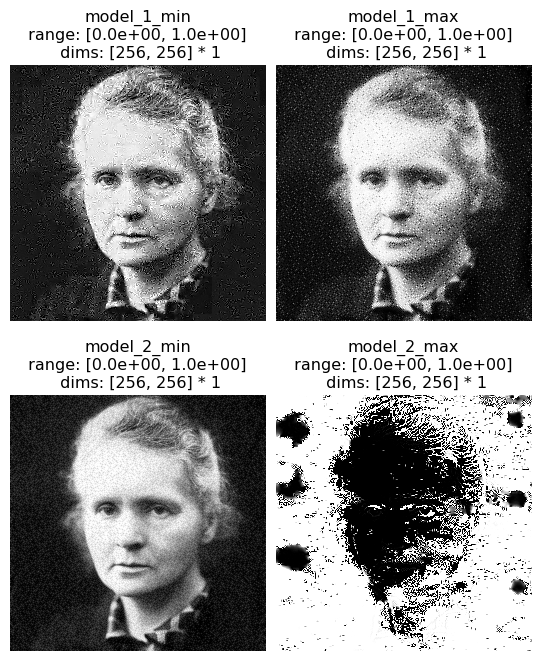

In [11]:
fig = mad.plot_synthesized_image_all()

## A note on metrics and models

There are two types of objects you can pass as your models to `MADCompetition` or other `Synthesis` methods: `torch.nn.Module` or functions.

1. Module: in this case, you're passing a visual *model*, which
   takes an image (as a 4d tensor) and returns some representation
   (as a 3d or 4d tensor). The model must have a `forward()` method
   that we can differentiate through (so, it should use pytorch
   methods, rather than numpy or scipy, unless you manually define
   the gradients in the backward() method). The distance we use is
   the distance between the model's representation
   of two images (by default this is the L2-norm of the difference of the two representations, to change, set ``loss_function`` to
   some other callable).

2. Function: in this case, you're passing a visual *metric*, a
   function which takes two images (as 4d tensors) and returns a
   distance between them (as a single-valued tensor), which is what
   we use as the distance for optimization purposes. This is
   slightly more general than the above, as you can do arbitrary
   calculations on the images, but you'll lose some of the power of
   the helper functions. For example, the plot of the representation
   and representation error will just be the pixel values and
   pixel-wise difference, respectively. This is because we construct
   a "dummy model" that just returns a duplicate of the image and
   use that throughout this class. You may have additional arguments
   you want to pass to your function, in which case you can pass a
   dictionary as ``model_1_kwargs`` (or ``model_2_kwargs``) during
   initialization. These will be passed during every call.

Synthesis methods have `plot_synthesis_status` and `animate` methods, which generate plots and animations to help you understand the synthesis. For metamers and MAD Competition, they will generate plots of the representation error (difference between the base and synthesized representations). The plot will be a stem plot if the representation is a vector and an image if it's a matrix. If your model has a `.plot_representation()` method, that will be used instead. In that case, your model should also have a `._update_plot()` method which specifies how to update the plot (see `PrimaryVisualCortex` model for an example). If you pass a function, then representation error will be uninformative (just a pixel-by-pixel difference of the image), and so you should probably turn it off.

## Advanced Usage

### Additional arguments

The synthesis methods in `plenoptic` share many features. Therefore, for details on coarsemany of the arguments in the `synthesize()` call, coarse-to-fine optimization, clamping, optimization arguments, resuming synthesis, saving/loading, moving to another device, and animation, see the [Metamer](./Metamer.ipynb) notebook.

Note that for coarse-to-fine optimization, setting it to `True` will only affect the target model; the stable model is always optimized as if `coarse_to_fine=False`.

There are some things that are specific to MAD Competition, however:
- `initial_noise`: as described above, the initial image used to start synthesis comes from the reference image with some noise added to it. That noise is normally distributed with a mean of 0 and a standard deviation of `initial_noise` (by default, `.1`)
- `fix_step_n_iter`: during synthesis, we're adjusting the image to change one model's loss while keeping the other stable. In order to keep the stable model's loss constant, we use a "stable loop", a secondary optimization loop that happens on each iteration of synthesis. Most of the optimization details of this stable loop cannot be changed (may change if necessary), but the number of iterations used to find the correct step size (`nu`) can be modified by changing `fix_step_n_iter`. If the stable model's loss seems to be changing too much, or the target model's loss doesn't change enough, playing with this parameter might fix it. The `nu` parameter is stored as an attribute (a list with a value for each iteration) that can be examined after synthesis.
- `norm_loss`: two models may have losses with greatly different magnitudes. In order to get the on the same scale (so one doesn't dominate the gradients), by default, we normalize the losses so that the initial loss is 1. To disable this behavior, set this to `False`.

### Modifying metric arguments

As noted above, you can pass a function to `MADCompetition` (and other synthesis methods) as a model. In order for that to work, we must be able to call the function on two 4d tensors with no other arguments and receive a scalar as the output:

In [12]:
po.metric.ssim(img, mad.matched_image)

tensor(0.0717, grad_fn=<MeanBackward0>)

Often, however, your metric function may have additional arguments you wish to set. You could write a wrapper function that calls the metric function with those specific arguments, or you could make use of the `model_1_kwargs` or `model_2_kwargs` argument (depending on whether the metric you wish to modify is `model_1` or `model_2` when initializing the `MADCompetition` object. These arguments are dictionaries that take `key:value` pairs, which will get passed to the metric when it gets called on the images.

For example, `po.metric.ssim` has a `window_size` argument, with a default value of `11`. When calling the function directly, we can pick another integer for that value, which results in a different output value:

In [13]:
po.metric.ssim(img, mad.matched_image, window_size=15)

tensor(0.0716, grad_fn=<MeanBackward0>)

To use this version of `ssim` in MAD Competition, you'd do the following:

In [14]:
model_1 = po.metric.ssim
model_2 = po.metric.naive.mse
model_1_kwargs = {'window_size': 15}
mad = po.synth.MADCompetition(img, model_1, model_2, model_1_kwargs=model_1_kwargs)

We can then call `synthesize()` and interact with the `MADCompetition` object as before, except that, anytime `model_1` gets called, it will get called with the additional keyword arguments we specified.

This same behavior works for all other synthesis methods, though the exact argument name will be different (e.g., `Metamer` only takes a single model, so the argument is called `model_kwargs`).

100%|██████████| 200/200 [00:47<00:00,  4.35it/s, gradient_norm=2.0206e-02, learning_rate=1, loss=2.5440e-01, stable_loss=1.0273e+00]


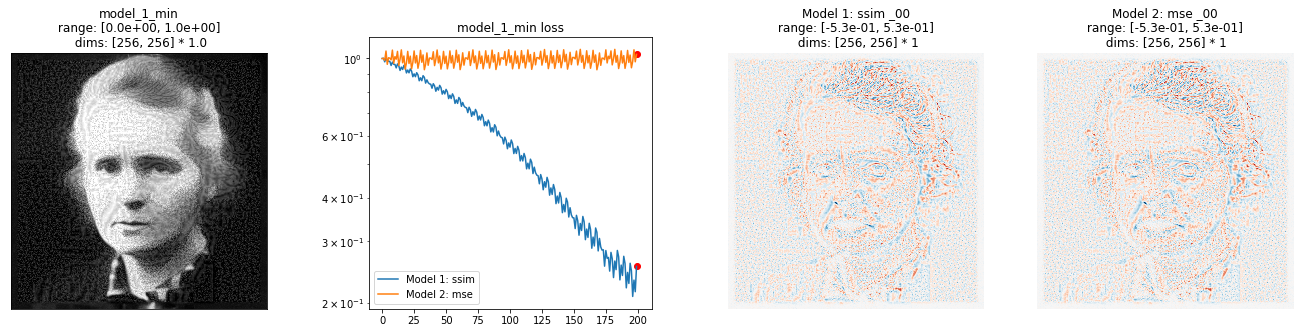

In [15]:
mad.synthesize('model_1_min', store_progress=True, max_iter=200)
fig = mad.plot_synthesis_status()

### Loss function

If you're not using metrics, but models instead, we need to use a loss function to transform the model's representation (which is likely a vector or matrix, not a scalar) of two images into a scalar, a single number we will try to minimize or maximize. By default, we use the L2-norm of the difference between the two representations, but you can change this by setting the `loss_function` argument during initialization of the `MADCompetition`.

Say we wanted to use the mean-squared error instead of the L2-norm of the difference when comparing NLPD and our Identity class. All we need to do is add `loss_function=po.optim.mse` when initializing `mad`.

In [16]:
model1 = po.metric.NLP()
model2 = po.simul.models.naive.Identity()

mad = po.synth.MADCompetition(img, model1, model2, loss_function=po.optim.mse)
mad.loss_function_1

<function plenoptic.synthesize.Synthesis.Synthesis.__init__.<locals>.wrapped_loss_func(synth_rep, ref_rep, synth_img, ref_img)>

Like when we modified `model_1_kwargs` above, once we set `loss_function` we can interact with the `mad` object as normal, and every time it would calculate the loss, it will use our new loss function instead.

Note that you must use the same loss function for both models. If you wish to use a specific loss for a model, you should probably present it as a metric instead.

100%|██████████| 200/200 [00:14<00:00, 14.21it/s, gradient_norm=1.7330e-02, learning_rate=1, loss=3.0004e-01, stable_loss=1.0268e+00]


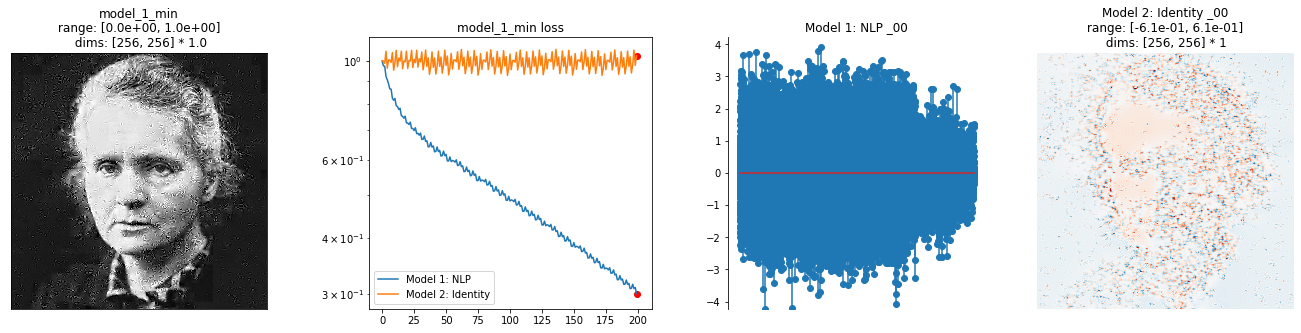

In [17]:
mad.synthesize('model_1_min', store_progress=True, max_iter=200)
fig = mad.plot_synthesis_status()

We can also get more complicated with our loss function, using not just the representations but also the image. The intended use case is that you want to penalize some property of the synthesized image, such as being beyond the range of the reference image or having a different mean. You can use the provided `Clamper` class to do that (see [Metamer](./Metamer.ipynb) notebook for more details), but that imposes a hard constraint and can interfere with the optimization; by adding a penalty to the loss function instead, you can enforce it as a soft constraint.

The `po.optim.penalize_range` function is provided for this purpose. It imposes a quadratic penalty on all values outside the `allowed_range` (`(0, 1)` by default). You can combine it with another loss, as seen in `po.optim.l2_and_penalize_range`, which is a weighted average  of the L2-norm of the difference in represntations (our default loss function) with the range penalty just described:

In [18]:
print(po.optim.l2_norm(mad.matched_representation_1, mad.target_representation_1))
print(po.optim.l2_and_penalize_range(mad.matched_representation_1, mad.target_representation_1, mad.matched_image))

tensor(220.3085, grad_fn=<NormBackward0>)
tensor(110.1543, grad_fn=<AddBackward0>)


By default, the weight is 50/50, which you can change by setting the `beta` argument. For the image just created, the range was clamped, so the range penalty contributes nothing and therefore the `l2_and_penalize_range` loss is just half the `l2_norm` loss. We can see that setting pixels outside the allowed range will increase the loss

In [19]:
tmp = mad.matched_image.clone()
tmp[:, 0] = -.1
print(po.optim.l2_and_penalize_range(mad.matched_representation_1, mad.target_representation_1, mad.matched_image))
print(po.optim.l2_and_penalize_range(mad.model_1(tmp), mad.target_representation_1, tmp))

tensor(110.1543, grad_fn=<AddBackward0>)
tensor(449.6455, grad_fn=<AddBackward0>)


We can insert use this loss during synthesis as we did above, setting `loss_function`. In this case, you probably want to disable the clamping by setting `clamper=None`. You may also want to change the weighting of the two components. You can do this by setting the `loss_kwargs` dictionary argument, similar to `model_1/2_kwargs` that we used earlier:

100%|██████████| 200/200 [00:20<00:00,  9.51it/s, gradient_norm=1.4171e-02, learning_rate=0.125, loss=7.4073e-01, stable_loss=1.0011e+00]


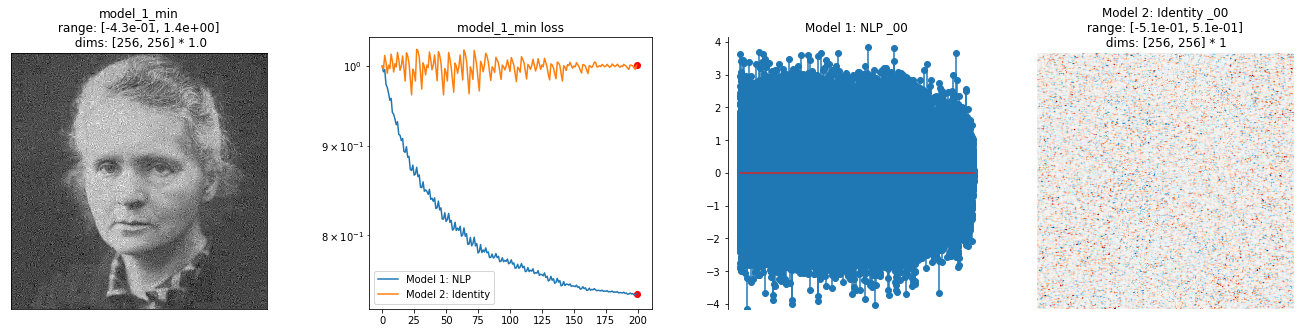

In [20]:
model1 = po.metric.NLP()
model2 = po.simul.models.naive.Identity()

mad = po.synth.MADCompetition(img, model1, model2, loss_function=po.optim.l2_and_penalize_range, loss_kwargs={'beta': .9})

mad.synthesize('model_1_min', store_progress=True, max_iter=200, clamper=None)
# By default, vrange will be (0, 1). Setting it to indep1 will show the true range.
fig = mad.plot_synthesis_status(vrange='indep1')

We provide a small collection of loss functions in `po.optim`, and you can write your own. If you do so, it must be able to accept all of these arguments: `synth_rep, ref_rep, synth_img, ref_img`. Most likely, you won't want to use all of those. If you only use some subset of them, you can swallow and ignore the rest by adding `**kwargs` to the end of your function signature (e.g., `def my_awesome_loss(synth_rep, ref_rep, **kwargs)`).

This functionality will work with other synthesis methods as well.

## Additional Attributes

The `MADCompetition` object has many attributes and methods. All arguments passed to `synthesize()` are stored as attributes.

Some other useful ones are as follows. 

Because MAD Competition works with two models at once, whereas most
synthesis methods only work with one, this class has "doubled
attributes", that is, for many attributes, `MADCompetition` has
two versions. For example, instead of a single `loss` attribute,
we have a `loss_1` and `loss_2` attribute, containing the loss
for `model_1` and `model_2`, respectively. For all attributes of
this type, you can access the one that is currently be modified
using the base string (e.g., `loss`), but it is recommended that
you stick with the explicit attributes unless you're sure you know
what you're doing.

Because a full set consists of four synthesized images, many
attributes below have a corresponding `_all` attribute, which is a
dictionary containing that data from each of the four synthesis
sets. For example, we have a `synthesized_signal_all` attribute, which
is a dictionary with four keys (the four possible values of
`synthesis_target`) that each contain the relevant synthesized
image.


1. `loss`, `gradient`, `learning_rate`: we store the current loss, gradient norm, and learning rate after each iteration.
2. `scales_loss`, `scales_timing`: if we're doing coarse-to-fine optimization, these are dictionaries holding the scale-specific loss and the iterations we switched to and from each scale.
3. `matched_image`, `matched_representation`: the synthesized image and the model's representation of it.
4. `target_image`, `target_representation`: the target image (the one whose representation we're trying to match) and the model's representation of it.
5. `saved_image`, `saved_image_gradient`, `saved_representation`, `saved_representation_gradient`: if we're storing progress, these attributes store the synthesized image-in-progress, its gradient, the model's representation of it, and the gradient of the representation.

Note that for those attributes that end in `_1/_2`, you can access the un-suffixed version (e.g., `mad.loss` exists), but it's just a pointer to that attribute for the relevant model. If you're not changing the details of synthesis, you shouldn't use this and should instead use the suffixed versions.